In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import os

In [2]:
torch.manual_seed(0)

In [3]:
def imshow(img):
    
    """
    Display an image in a matplotlib plot.

    Args:
        img (tensor): The image to be displayed, as a PyTorch tensor. The tensor
        should have shape (3, H, W), where H and W are the height and width of the
        image, respectively.

    Returns:
        None.

    Notes:
        This function assumes that the input image has been normalized using the
        transforms.Normalize method with mean (0.5, 0.5, 0.5) and standard deviation
        (0.5, 0.5, 0.5). The function first unnormalizes the pixel values by
        scaling them by 2 and adding 0.5. It then converts the tensor to a numpy
        array and transposes the dimensions so that the color channels are the
        last dimension, in RGB order. Finally, it displays the image in a
        matplotlib plot.

    """
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

def train(net, trainloader, device, epochs=4, print_every=2000, learning_rate=0.001, momentum=0.9):
    """
    Trains a PyTorch neural network using a cross entropy loss function and stochastic gradient descent optimizer.
    
    Args:
    - net: A PyTorch neural network model to train.
    - trainloader: A PyTorch DataLoader representing the training set.
    - device: A string indicating the device to use for training (e.g. 'cuda' or 'cpu').
    - epochs (optional): An integer indicating the number of epochs to train for (default 4).
    - print_every (optional): An integer indicating how often to print the loss during training (default 2000).
    - learning_rate (optional): A float indicating the learning rate for the optimizer (default 0.001).
    - momentum (optional): A float indicating the momentum for the optimizer (default 0.9).
    """
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            # inputs, labels = data
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % print_every == print_every - 1:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_every:.3f}')
                running_loss = 0.0

    print('Finished Training')

    
def naive_accuracy(net, dataloader, classes, per_class=False):
    """
    Computes the accuracy of a neural network on a given dataset.
    
    Args:
        net (torch.nn.Module): the neural network to evaluate
        dataloader (torch.utils.data.DataLoader): a dataloader for the dataset
        classes (list): a list of class names corresponding to the labels in the dataset
        per_class (bool): whether to compute the accuracy per class or the overall accuracy
    
    Returns:
        float or dict: the accuracy as a percentage if per_class is False, 
                       or a dictionary mapping each class to its accuracy if per_class is True
    """
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    if per_class:
        # print accuracy for each class
        accuracies = {}
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            accuracies[classname] = accuracy
        return accuracies
    else:
        # compute overall accuracy
        total_correct = sum(correct_pred.values())
        total_pred = sum(total_pred.values())
        accuracy = 100 * total_correct / total_pred
        return accuracy


def resize_normalize(img_path):
    
    """ Resize 512 by 512 rgb images that we get from stable diffusion, convert to pytorch tensor, then normalize
    """
    
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize to 32x32
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
    ])

    image = Image.open(img_path)  # Load your image
    image = transform(image)  # Apply the transform
    return(image)

def cfar_transform(cfar_img):
    
    """
    Transform and normalize an image from the CIFAR-10 dataset using PyTorch transforms.

    Args:
        cfar_img (PIL Image or numpy.ndarray): The image to be transformed.

    Returns:
        tensor: The transformed image as a PyTorch tensor, with pixel values
        normalized to the range [-1, 1]. The tensor has shape (3, H, W), where H and
        W are the height and width of the original image, respectively.

    Notes:
        This function applies the following transformations to the input image in
        sequence: convert the image to a PyTorch tensor, then normalize the pixel
        values of each color channel to have mean 0.5 and standard deviation 0.5.
        The resulting tensor has shape (3, H, W), where 3 corresponds to the three
        color channels (red, green, and blue).

        This function assumes that the input image has already been loaded using
        PyTorch's ImageFolder dataset, and is therefore in PIL Image format or
        numpy.ndarray format.

    """
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    return(transform(cfar_img))

def load_and_transform_images(img_dir):
    """
    Loads and transforms images from a specified directory.

    Args:
        img_dir (str): The directory containing the images.

    Returns:
        torch.Tensor: A tensor containing the processed images.
    """
    # Get a list of the image paths
    img_paths = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.png')]

    # Process each image and store the result in a list
    new_images = [resize_normalize(img_path) for img_path in img_paths]

    # Convert the list of images to a tensor
    new_images = torch.stack(new_images)

    return new_images

In [4]:
class Net(nn.Module):
    """
    A simple neural network architecture for image classification with three convolutional layers.

    The architecture consists of three convolutional layers followed by three fully connected layers. The input to
    the network should be a tensor of shape (batch_size, 3, height, width), where height and width are the dimensions of
    the input image, and the output should be a tensor of shape (batch_size, 10), where each element represents the
    predicted score for one of the 10 classes in the CIFAR-10 dataset.

    Attributes:
        conv1 (nn.Conv2d): The first convolutional layer.
        pool (nn.MaxPool2d): The max pooling layer.
        conv2 (nn.Conv2d): The second convolutional layer.
        conv3 (nn.Conv2d): The third convolutional layer.
        fc1 (nn.Linear): The first fully connected layer.
        fc2 (nn.Linear): The second fully connected layer.
        fc3 (nn.Linear): The output layer.

    Methods:
        forward(x): Defines the forward pass of the network.

    """

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 1 * 1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Args:
            x (tensor): The input tensor, of shape (batch_size, 3, height, width).

        Returns:
            tensor: The output tensor, of shape (batch_size, 10).

        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


    
class CustomDataset(torch.utils.data.Dataset):
    """
    CustomDataset class that extends the torch.utils.data.Dataset class.

    Args:
        images (list): A list of image data.
        labels (list): A list of labels corresponding to each image.

    Attributes:
        images (list): A list of image data.
        labels (list): A list of labels corresponding to each image.

    Methods:
        __getitem__(self, index): Retrieves an image and label corresponding to the given index.
        __len__(self): Returns the total number of images in the dataset.
    """

    def __init__(self, images, labels):
        """
        Initializes a new CustomDataset instance with the given images and labels.
        """
        self.images = images
        self.labels = labels

    def __getitem__(self, index):
        """
        Retrieves the image and label corresponding to the given index.

        Args:
            index (int): The index of the image and label to retrieve.

        Returns:
            tuple: A tuple containing the image and label.
        """
        image = self.images[index]
        label = self.labels[index]
        return image, label

    def __len__(self):
        """
        Returns the total number of images in the dataset.

        Returns:
            int: The total number of images in the dataset.
        """
        return len(self.images)


In [24]:
# Define some global variables

synthetic_imgDir = "D:\\Projects\\synthetic_diffusion\\data\\cats"

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch_size = 16

device = 'cuda' if torch.cuda.is_available() else 'cpu' # If gpu exists use cuda

In [6]:
# Define networks

#custom_net = Net() # Cifar10 + synthetic images
custom_net = Net()
custom_net.to(device)

#vanilla_net = Net() # Cifar 10 only
vanilla_net = Net()
vanilla_net.to(device)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=32, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
# Define transform to convert images to tensor and normalize

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
# Load data for CIFAR dataset

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Load and transform synthetic images

custom_images = load_and_transform_images(synthetic_imgDir)
custom_labels = len(custom_images)*[3]  # Your assigned labels(cat)

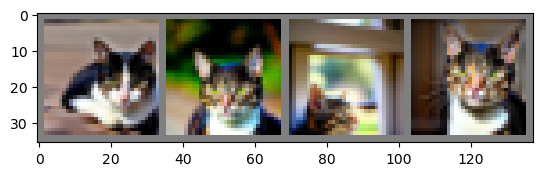

In [10]:
# Let's take a look at a few of our synthetic cat images

imshow(torchvision.utils.make_grid(custom_images[0:4]))

In [11]:
# Normalize cfar images

cfar_images = [cfar_transform(cfar_image) for cfar_image in trainset.data]
cfar_images = torch.stack(cfar_images)

In [12]:
# Concatenate our synthetic images with cfar images

custom_train_images = torch.cat((cfar_images, custom_images), dim=0)
custom_train_labels = trainset.targets + custom_labels

In [13]:
# Create a custom dataloader for our new combined dataset

custom_trainset = CustomDataset(custom_train_images, custom_train_labels)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

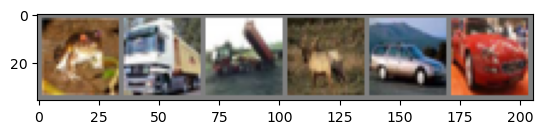

frog  truck truck deer  car   car  


In [14]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [15]:
# train the vanilla model
train(vanilla_net, trainloader, device, epochs=5, print_every=4000, learning_rate=0.001, momentum=0.9)

[1,  4000] loss: 2.261
[1,  8000] loss: 1.777
[2,  4000] loss: 1.506
[2,  8000] loss: 1.406
[3,  4000] loss: 1.330
[3,  8000] loss: 1.276
[4,  4000] loss: 1.223
[4,  8000] loss: 1.176
[5,  4000] loss: 1.146
[5,  8000] loss: 1.110
Finished Training


In [16]:
# train the custom model
train(custom_net, custom_trainloader, device, epochs=5, print_every=4000, learning_rate=0.001, momentum=0.9)

[1,  4000] loss: 2.179
[1,  8000] loss: 1.714
[2,  4000] loss: 1.508
[2,  8000] loss: 1.412
[3,  4000] loss: 1.336
[3,  8000] loss: 1.300
[4,  4000] loss: 1.238
[4,  8000] loss: 1.218
[5,  4000] loss: 1.172
[5,  8000] loss: 1.168
Finished Training


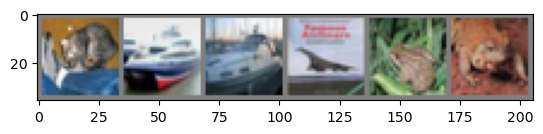

GroundTruth:  cat   ship  ship  plane frog  frog 


In [17]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(6)))

In [18]:
outputs = vanilla_net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(6)))

Predicted:  cat   ship  ship  plane frog  frog 


In [19]:
outputs = custom_net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(6)))

Predicted:  cat   ship  ship  plane frog  frog 


In [20]:
naive_accuracy(vanilla_net, testloader, classes, per_class=False)

59.48

In [21]:
naive_accuracy(vanilla_net, testloader, classes, per_class=True)

{'plane': 67.1,
 'car': 74.8,
 'bird': 39.9,
 'cat': 45.6,
 'deer': 52.7,
 'dog': 32.2,
 'frog': 59.3,
 'horse': 76.9,
 'ship': 79.0,
 'truck': 67.3}

In [22]:
naive_accuracy(custom_net, testloader, classes, per_class=False)

57.28

In [23]:
naive_accuracy(custom_net, testloader, classes, per_class=True)

{'plane': 66.0,
 'car': 80.9,
 'bird': 32.7,
 'cat': 54.4,
 'deer': 33.1,
 'dog': 40.8,
 'frog': 63.1,
 'horse': 70.7,
 'ship': 65.6,
 'truck': 65.5}

In [12]:
import streamlit as st

# Load and transform synthetic images
custom_images = load_and_transform_images(synthetic_imgDir)
custom_labels = len(custom_images) * [3]  # Your assigned labels(cat)

# Define slider for selecting number of custom images to add
num_custom_images = st.slider('Select number of custom images to add to dataset', 0, len(custom_images), step=10)

# Normalize CIFAR-10 images
cfar_images = [cfar_transform(cfar_image) for cfar_image in trainset.data]
cfar_images = torch.stack(cfar_images)

# Concatenate our synthetic images with CIFAR-10 images
custom_train_images = torch.cat((cfar_images, custom_images[:num_custom_images]), dim=0)
custom_train_labels = trainset.targets + custom_labels[:num_custom_images]

# Create a custom dataloader for our new combined dataset
custom_trainset = CustomDataset(custom_train_images, custom_train_labels)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

# Train the network using the custom dataloader
train(custom_net, custom_trainloader, device, epochs=5, print_every=4000, learning_rate=0.001, momentum=0.9)


2023-03-28 01:00:10.037 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2023-03-28 01:00:10.178 
  command:

    streamlit run C:\Users\mongo\anaconda3\envs\synthetic_diffusion\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


[1,  4000] loss: 2.167
[1,  8000] loss: 1.703
[2,  4000] loss: 1.498
[2,  8000] loss: 1.421
[3,  4000] loss: 1.337
[3,  8000] loss: 1.299
[4,  4000] loss: 1.239
[4,  8000] loss: 1.227
[5,  4000] loss: 1.180
[5,  8000] loss: 1.167
Finished Training
